In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()
# 3) If you’re using PyTorch + CUDA, free any lingering GPU memory
import torch
torch.cuda.empty_cache()

import importlib
from libs import models, plots, trades, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(trades)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

from tqdm import tqdm
import matplotlib.pyplot as plt   
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])


In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_man
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_end          = params.regular_end
look_back            = params.look_back
trailing_stop_thresh = params.trailing_stop_thresh_man

# month to inspect (YYYY-MM)
date_to_check = params.date_to_check

# model path
val_rmse_str = "0.2537"   # same rmse in the filename

csv_dir: str = "./dfs training"
path_csv_load = f"{csv_dir}/{ticker}_final.csv"
path_csv_save = f"{csv_dir}/{ticker}_test_DF.csv"

model_path = save_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs training/GOOGL_0.2537.pth')

In [3]:
df = pd.read_csv(path_csv_load, index_col=0, parse_dates=True)
df

open        high         low       close  \
2014-04-03 12:06:00   28.644845   28.644845   28.644845   28.644845   
2014-04-03 12:07:00   28.639690   28.639690   28.639690   28.639690   
2014-04-03 12:08:00   28.634534   28.634534   28.634534   28.634534   
2014-04-03 12:09:00   28.629379   28.629379   28.629379   28.629379   
2014-04-03 12:10:00   28.624224   28.624224   28.624224   28.624224   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  173.375000  173.677100  173.215000  173.565000   
2025-06-18 20:57:00  173.565000  173.590000  173.240000  173.380000   
2025-06-18 20:58:00  173.390000  173.410000  173.200000  173.310000   
2025-06-18 20:59:00  173.315000  173.400000  173.230000  173.280000   
2025-06-18 21:00:00  173.300000  174.050000  173.170000  173.609700   

                        volume       r_1       r_5      r_15    vol_15  \
2014-04-03 12:06:00     4580.0 -0.000180 -0.000180 -0.000180  0.000046   
2014-04-03 12:07:00     4540.0 -0.000180 -0.000360 -0.000360  0.000063   
2014-04-03 12:08:00     4500.0 -0.000180 -0.000540 -0.000540  0.000075   
2014-04-03 12:09:00     4460.0 -0.000180 -0.000720 -0.000720  0.000082   
2014-04-03 12:10:00     4420.0 -0.000180 -0.000900 -0.000900  0.000088   
...                        ...       ...       ...       ...       ...   
2025-06-18 20:56:00   621199.0  0.001124 -0.004226 -0.009661  0.001493   
2025-06-18 20:57:00   624198.0 -0.001066 -0.005063 -0.010671  0.001487   
2025-06-18 20:58:00   454542.0 -0.000404 -0.005811 -0.011816  0.001436   
2025-06-18 20:59:00  1094746.0 -0.000173 -0.004434 -0.011932  0.001432   
2025-06-18 21:00:00  7649838.0  0.001901  0.001382 -0.009290  0.001592   

                     volume_spike  vwap_dev     rsi_14         bid  \
2014-04-03 12:06:00      0.568641 -0.000177   0.000000   28.636251   
2014-04-03 12:07:00      0.570338 -0.000352   0.000000   28.631098   
2014-04-03 12:08:00      0.574408 -0.000524   0.000000   28.625944   
2014-04-03 12:09:00      0.581017 -0.000694   0.000000   28.620791   
2014-04-03 12:10:00      0.590413 -0.000862   0.000000   28.615637   
...                           ...       ...        ...         ...   
2025-06-18 20:56:00      2.462713  1.248428  17.019768  173.512900   
2025-06-18 20:57:00      2.154838  1.246015  11.648165  173.328000   
2025-06-18 20:58:00      1.439161  1.245096  11.384870  173.258000   
2025-06-18 20:59:00      2.836382  1.244678  11.830567  173.228000   
2025-06-18 21:00:00      8.568493  1.248745  22.962317  173.557600   

                            ask  signal_smooth  
2014-04-03 12:06:00   28.653438       0.327384  
2014-04-03 12:07:00   28.648282       0.328556  
2014-04-03 12:08:00   28.643125       0.329833  
2014-04-03 12:09:00   28.637968       0.331213  
2014-04-03 12:10:00   28.632811       0.332697  
...                         ...            ...  
2025-06-18 20:56:00  173.617100       0.000000  
2025-06-18 20:57:00  173.432000       0.000000  
2025-06-18 20:58:00  173.362000       0.000000  
2025-06-18 20:59:00  173.332000       0.000000  
2025-06-18 21:00:00  173.661800       0.000000  

[1651679 rows x 15 columns]

In [4]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back   = look_back,
    regular_start   = regular_start_pred,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.train_batch
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.train_batch,
    train_workers=params.num_workers
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=891515, val=206611, te=215633
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..409], total days=410
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 410
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# Load the entire model object (architecture + weights)
model_best = torch.load(model_path, map_location=device, weights_only=False)
model_best.to(device).eval()
model_best

DualMemoryLSTM(
  (short_lstm): LSTM(12, 32, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(32, 64, batch_first=True)
  (do_long): Dropout(p=0.35, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.53559
Test zero‐forecast baseline RMSE = 0.56022


std val: 0.33184102
std test: 0.3439473


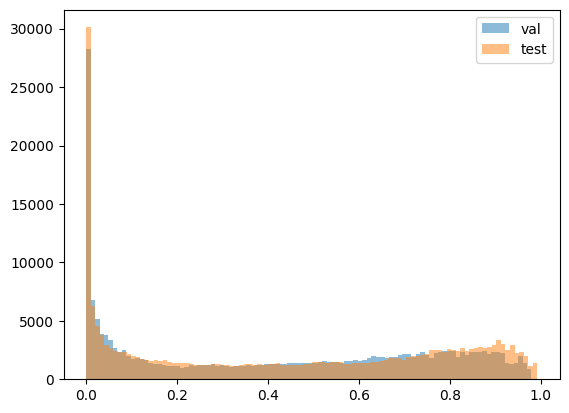

In [8]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [9]:

def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test",
    compute_rmse: bool = True,
    collect_preds: bool = False
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:
      - compute_rmse: if True, accumulates MSE and returns RMSE
      - collect_preds: if True, gathers every window's prediction into a flat array

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None

    You can call:
      rmse, _     = evaluate_model(model, loader, device, split_name, True, False)
      _, preds    = evaluate_model(model, loader, device, split_name, False, True)
      rmse, preds = evaluate_model(model, loader, device, split_name, True, True)
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats if requested
            if compute_rmse:
                total_sq_error += (pred - y).pow(2).sum().item()
                total_windows  += y.numel()

            # collect raw preds if requested
            if collect_preds:
                all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    if compute_rmse:
        rmse = math.sqrt(total_sq_error / total_windows)
        print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    if collect_preds:
        preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [10]:
val_rmse, _     = evaluate_model(model_best, val_loader, device, split_name="Validation")
test_rmse, _     = evaluate_model(model_best, test_loader, device, split_name="Test")

_, preds = evaluate_model(model_best, test_loader, device,
                          split_name="Test",
                          compute_rmse=False, collect_preds=True)

preds.shape

Validation: 100%|██████████| 410/410 [00:02<00:00, 179.16day/s]



Validation RMSE over 206611 windows = 0.25353


Test: 100%|██████████| 422/422 [00:01<00:00, 259.48day/s]



Test RMSE over 215633 windows = 0.29302


Test: 100%|██████████| 422/422 [00:01<00:00, 257.93day/s]


(215633,)

In [13]:

def add_pred_actions(df: pd.DataFrame, preds: np.ndarray) -> pd.DataFrame:
    """
    1) Stamp preds on the exact minute-bars your model saw.
    2) Take only those rows (the “test split”) and
       generate trade actions on them.
    3) Return the smaller DF.
    """
    # 0) copy & init
    df = df.copy()
    df["pred_signal"] = np.nan

    # 1) build valid_idx exactly as before
    valid_ts = []
    days = sorted(df.index.normalize().unique())
    # replay the test-day logic via day_id_te:
    test_global_ids = np.unique(day_id_te)
    for gid in test_global_ids:
        day = days[int(gid)]
        day_df = df[df.index.normalize() == day].sort_index()

        # drop first LOOK_BACK bars, then mask times >= regular_start_pred
        ends = day_df.index[look_back:]
        mask = ends.time >= regular_start_pred
        valid_ts.append(ends[mask])

    valid_idx = pd.DatetimeIndex(np.concatenate([ts.values for ts in valid_ts]))

    if len(valid_idx) != len(preds):
        raise ValueError(f"{len(valid_idx)} slots vs {len(preds)} preds")

    df.loc[valid_idx, "pred_signal"] = preds

    # 2) slice to only test-rows
    df_test = df.loc[valid_idx]

    # 3) generate trade actions per test-day only
    outs = []
    for _, day_df in df_test.groupby(df_test.index.normalize(), sort=False):
        outs.append(
            trades.generate_trade_actions(
                df                   = day_df,
                col_signal           = "pred_signal",
                col_action           = "pred_action",
                buy_threshold        = pred_threshold,
                trailing_stop_thresh = trailing_stop_thresh,
                regular_start        = regular_start
            )
        )

    df_out = pd.concat(outs).sort_index()
    df_out.to_csv(path_csv_save)
    return df_out


In [14]:
df_with_preds = add_pred_actions(
    df, preds
)

df_with_preds

open      high      low     close     volume  \
2023-10-12 12:30:00  141.270  141.2900  141.250  141.2900       21.0   
2023-10-12 12:31:00  141.270  141.2950  141.250  141.2750      140.0   
2023-10-12 12:32:00  141.270  141.3000  141.250  141.2600      259.0   
2023-10-12 12:33:00  141.300  141.3000  141.290  141.2900      200.0   
2023-10-12 12:34:00  141.300  141.3000  141.300  141.3000      100.0   
...                      ...       ...      ...       ...        ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650   621199.0   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800   624198.0   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100   454542.0   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  1094746.0   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  7649838.0   

                          r_1       r_5      r_15    vol_15  volume_spike  \
2023-10-12 12:30:00 -0.000071 -0.000566 -0.001627  0.000210      0.086861   
2023-10-12 12:31:00 -0.000106 -0.000814 -0.001733  0.000208      0.559180   
2023-10-12 12:32:00 -0.000106 -0.000425 -0.001980  0.000195      0.975273   
2023-10-12 12:33:00  0.000212 -0.000142 -0.001697  0.000214      0.720548   
2023-10-12 12:34:00  0.000071  0.000000 -0.001414  0.000217      0.353815   
...                       ...       ...       ...       ...           ...   
2025-06-18 20:56:00  0.001124 -0.004226 -0.009661  0.001493      2.462713   
2025-06-18 20:57:00 -0.001066 -0.005063 -0.010671  0.001487      2.154838   
2025-06-18 20:58:00 -0.000404 -0.005811 -0.011816  0.001436      1.439161   
2025-06-18 20:59:00 -0.000173 -0.004434 -0.011932  0.001432      2.836382   
2025-06-18 21:00:00  0.001901  0.001382 -0.009290  0.001592      8.568493   

                     vwap_dev     rsi_14       bid       ask  signal_smooth  \
2023-10-12 12:30:00  1.174955  20.512821  141.2476  141.3324       0.007284   
2023-10-12 12:31:00  1.174724  15.584416  141.2326  141.3174       0.008106   
2023-10-12 12:32:00  1.174493  15.384615  141.2176  141.3024       0.008361   
2023-10-12 12:33:00  1.174955  23.076923  141.2476  141.3324       0.008043   
2023-10-12 12:34:00  1.175109  26.315789  141.2576  141.3424       0.008000   
...                       ...        ...       ...       ...            ...   
2025-06-18 20:56:00  1.248428  17.019768  173.5129  173.6171       0.000000   
2025-06-18 20:57:00  1.246015  11.648165  173.3280  173.4320       0.000000   
2025-06-18 20:58:00  1.245096  11.384870  173.2580  173.3620       0.000000   
2025-06-18 20:59:00  1.244678  11.830567  173.2280  173.3320       0.000000   
2025-06-18 21:00:00  1.248745  22.962317  173.5576  173.6618       0.000000   

                     pred_signal  pred_action  
2023-10-12 12:30:00     0.181313            0  
2023-10-12 12:31:00     0.188319            0  
2023-10-12 12:32:00     0.198142            0  
2023-10-12 12:33:00     0.211305            0  
2023-10-12 12:34:00     0.224193            0  
...                          ...          ...  
2025-06-18 20:56:00     0.424661            0  
2025-06-18 20:57:00     0.413375            0  
2025-06-18 20:58:00     0.427578            0  
2025-06-18 20:59:00     0.453742            0  
2025-06-18 21:00:00     0.424435            0  

[215633 rows x 17 columns]

In [15]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,              # full DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,       
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2025-03:


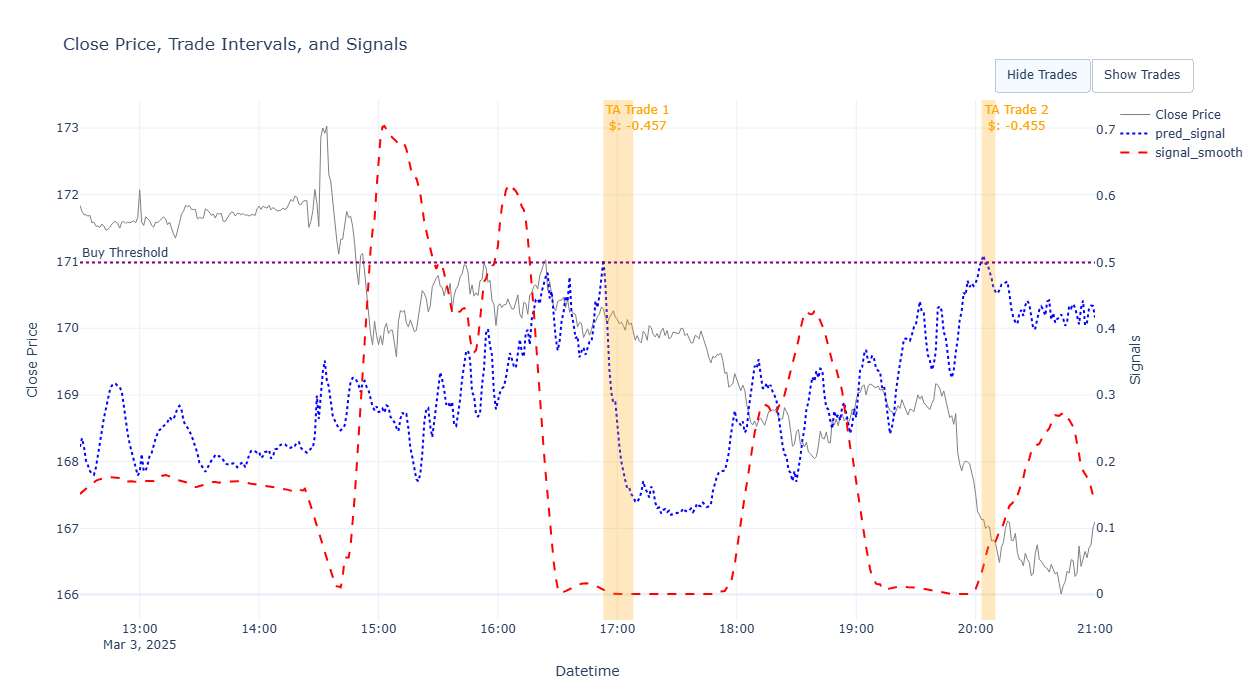


=== Performance for 2025-03-03 00:00:00 ===
Strategy Return ($): -0.912
Buy & Hold Return ($): -4.617
Trades Returns ($): [-0.457, -0.455]


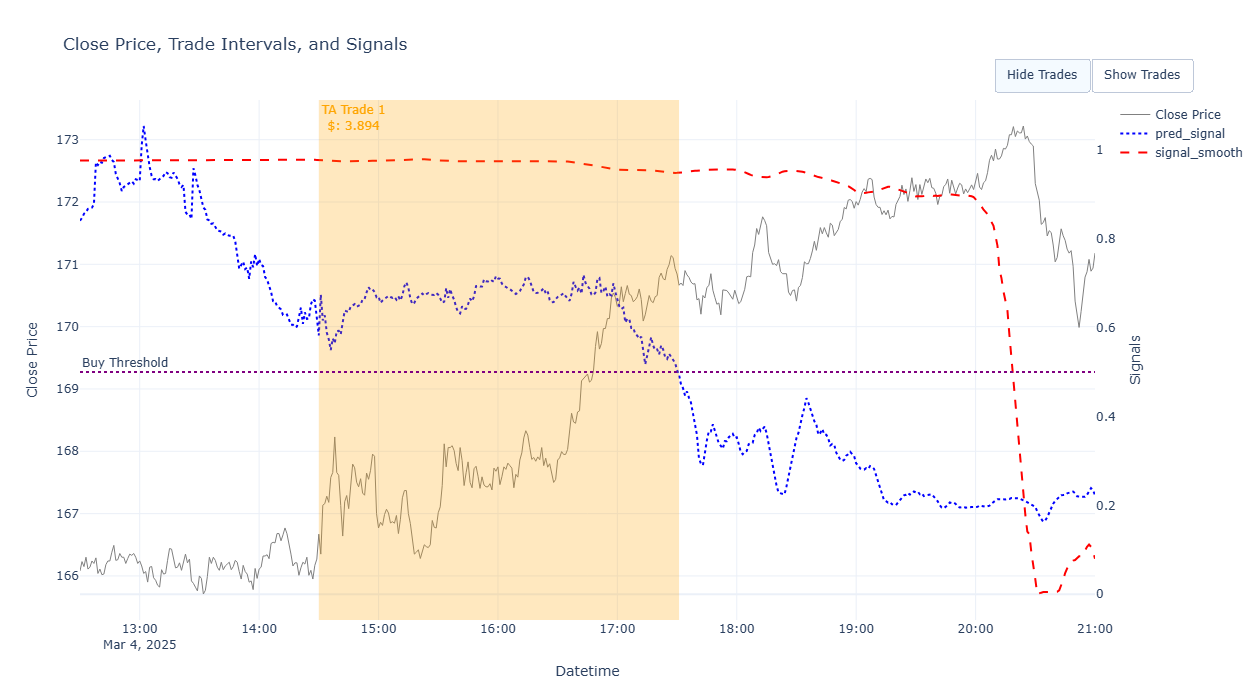


=== Performance for 2025-03-04 00:00:00 ===
Strategy Return ($): 3.894
Buy & Hold Return ($): 4.169
Trades Returns ($): [3.894]


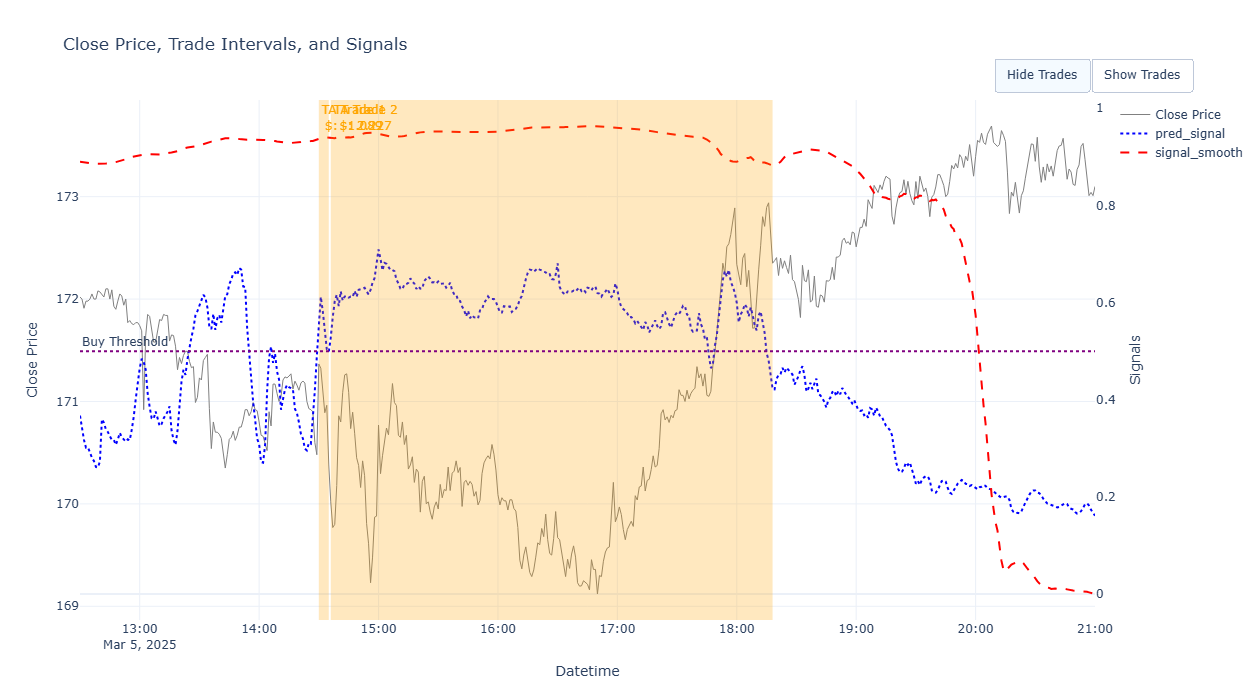


=== Performance for 2025-03-05 00:00:00 ===
Strategy Return ($): 1.139
Buy & Hold Return ($): 1.54
Trades Returns ($): [-1.089, 2.227]


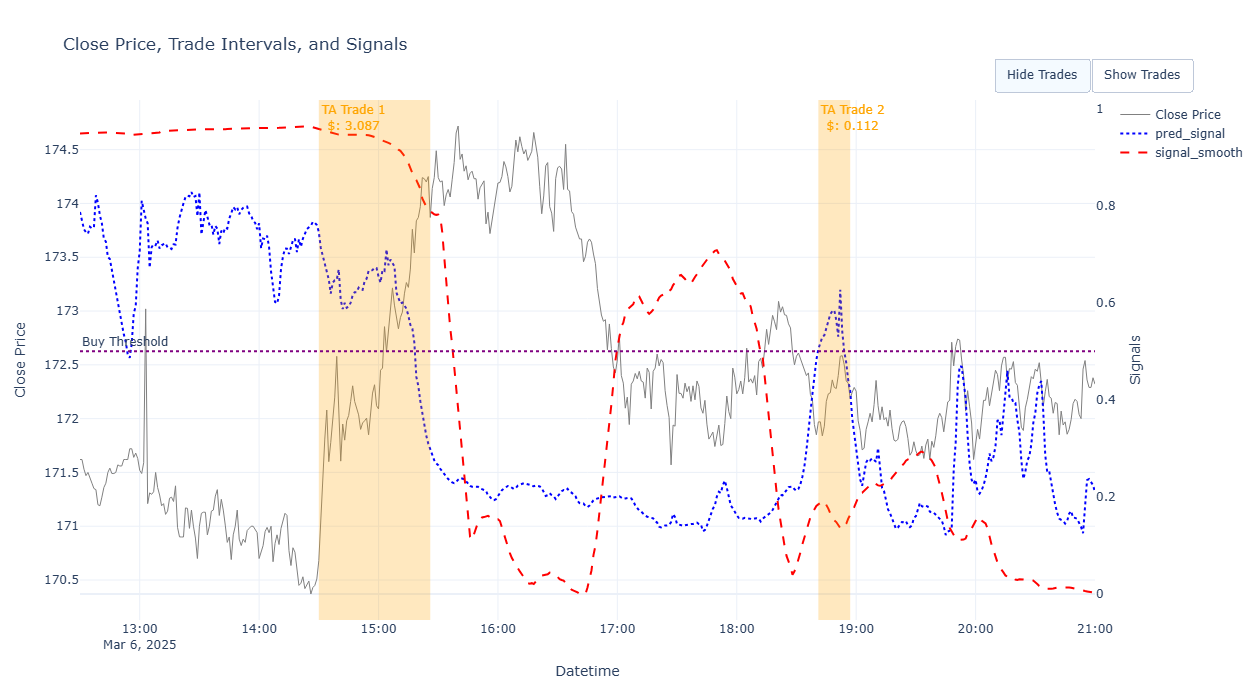


=== Performance for 2025-03-06 00:00:00 ===
Strategy Return ($): 3.198
Buy & Hold Return ($): 1.597
Trades Returns ($): [3.087, 0.112]


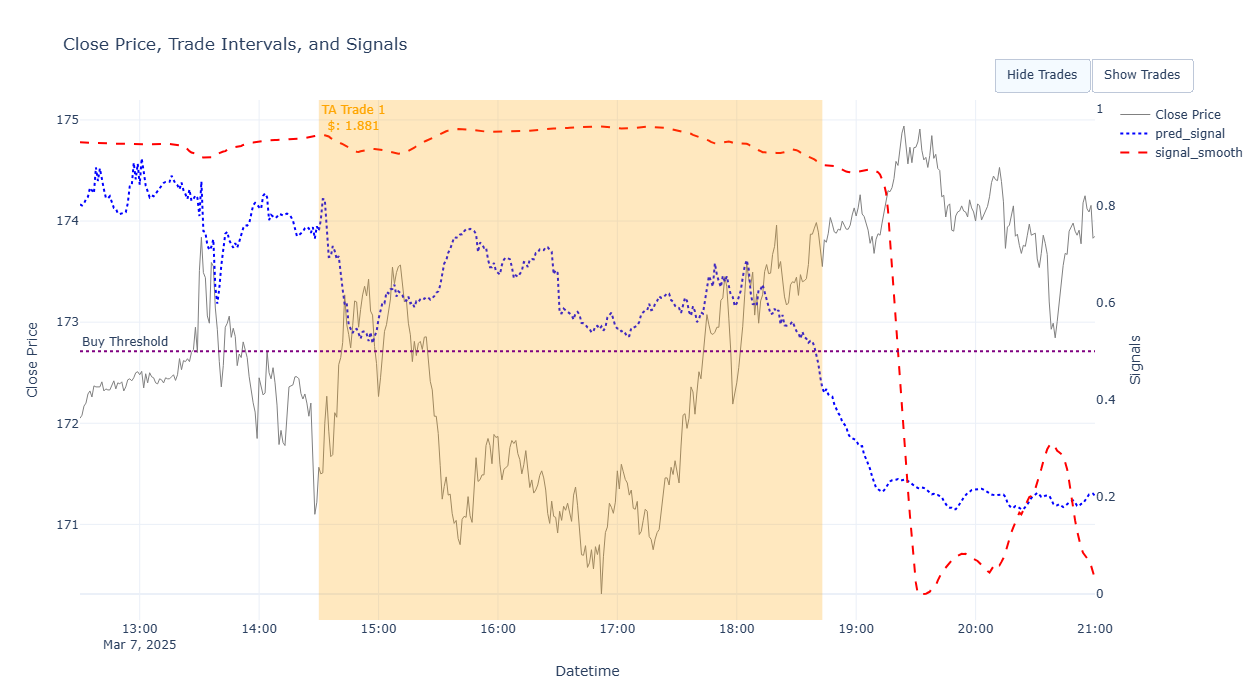


=== Performance for 2025-03-07 00:00:00 ===
Strategy Return ($): 1.881
Buy & Hold Return ($): 2.161
Trades Returns ($): [1.881]


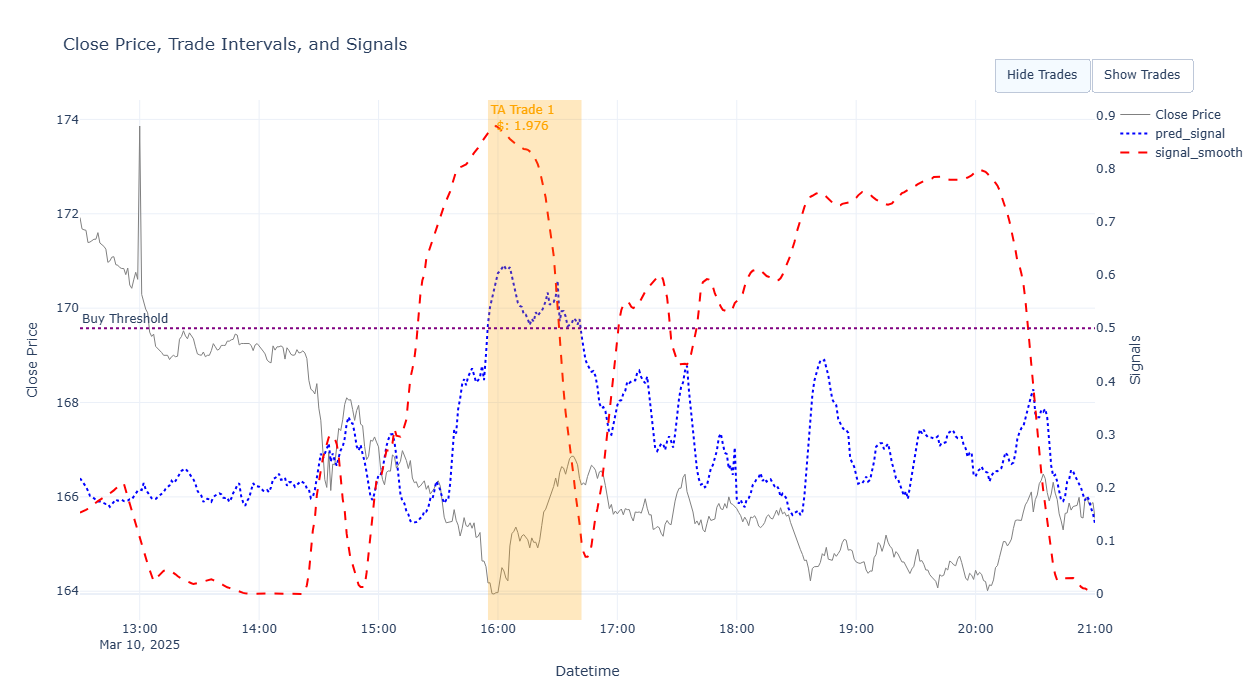


=== Performance for 2025-03-10 00:00:00 ===
Strategy Return ($): 1.976
Buy & Hold Return ($): -2.1
Trades Returns ($): [1.976]


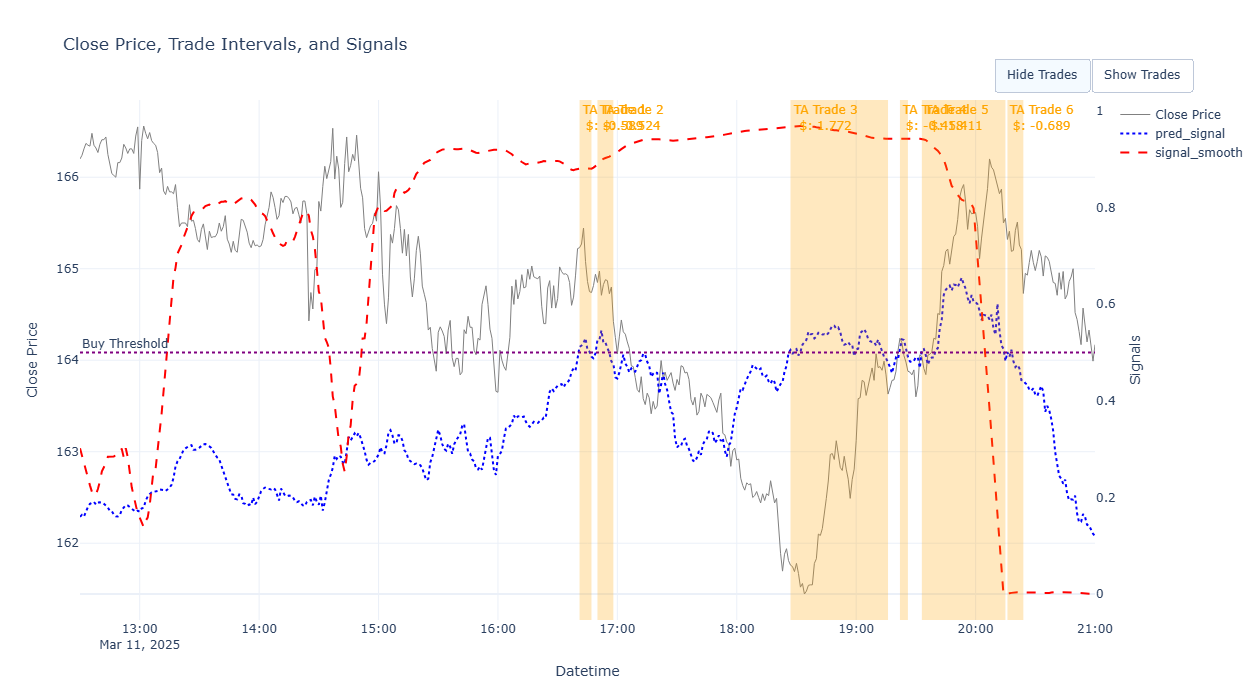


=== Performance for 2025-03-11 00:00:00 ===
Strategy Return ($): 0.923
Buy & Hold Return ($): -1.844
Trades Returns ($): [-0.589, -0.524, 1.772, -0.458, 1.411, -0.689]


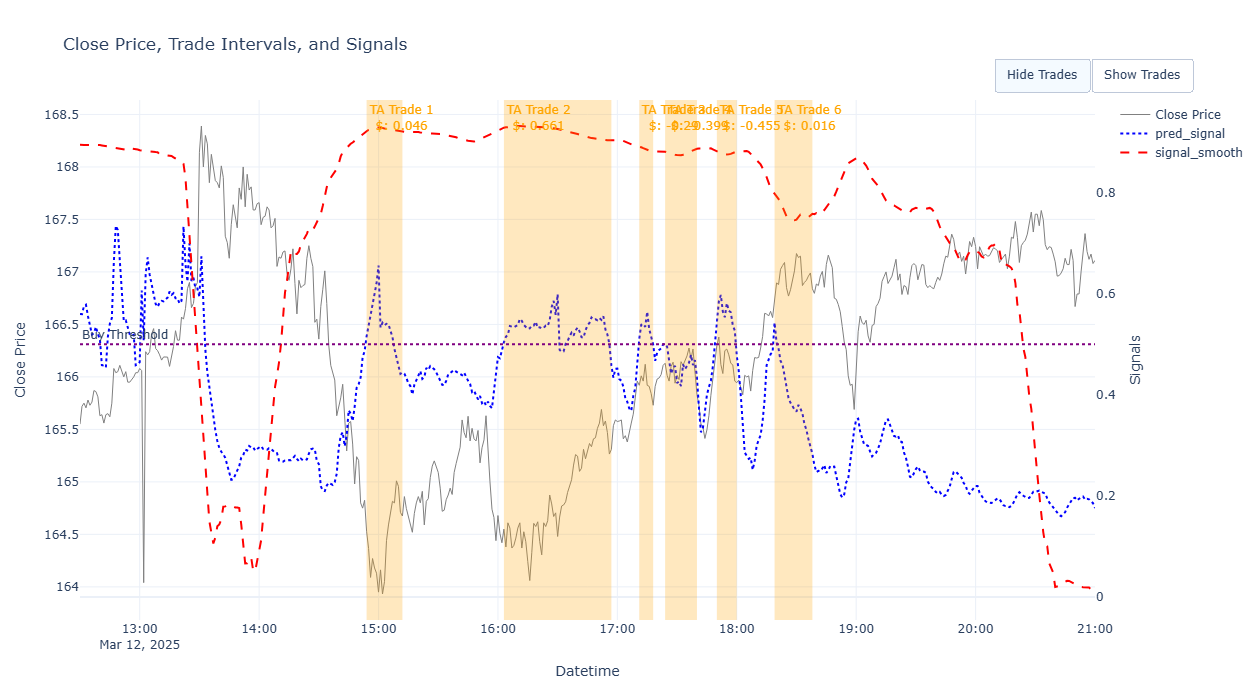


=== Performance for 2025-03-12 00:00:00 ===
Strategy Return ($): -0.421
Buy & Hold Return ($): 0.62
Trades Returns ($): [0.046, 0.661, -0.29, -0.399, -0.455, 0.016]


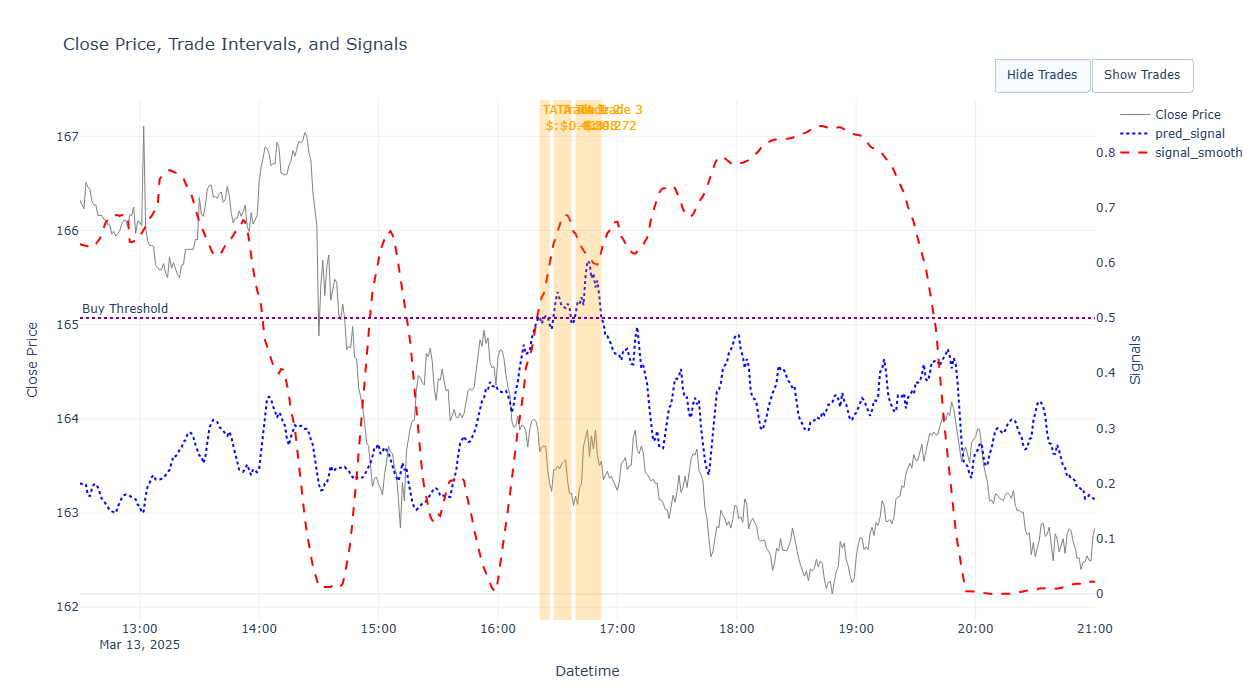


=== Performance for 2025-03-13 00:00:00 ===
Strategy Return ($): -0.514
Buy & Hold Return ($): -2.218
Trades Returns ($): [-0.438, -0.348, 0.272]


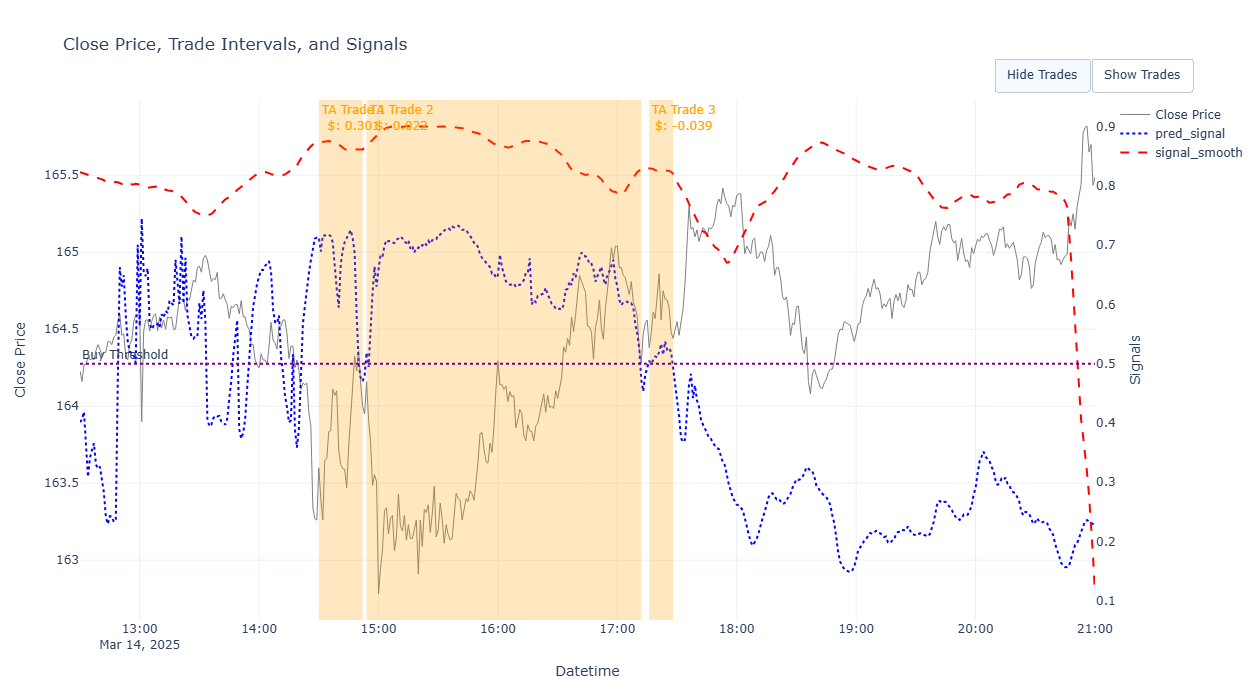


=== Performance for 2025-03-14 00:00:00 ===
Strategy Return ($): 0.285
Buy & Hold Return ($): 1.736
Trades Returns ($): [0.301, 0.022, -0.039]


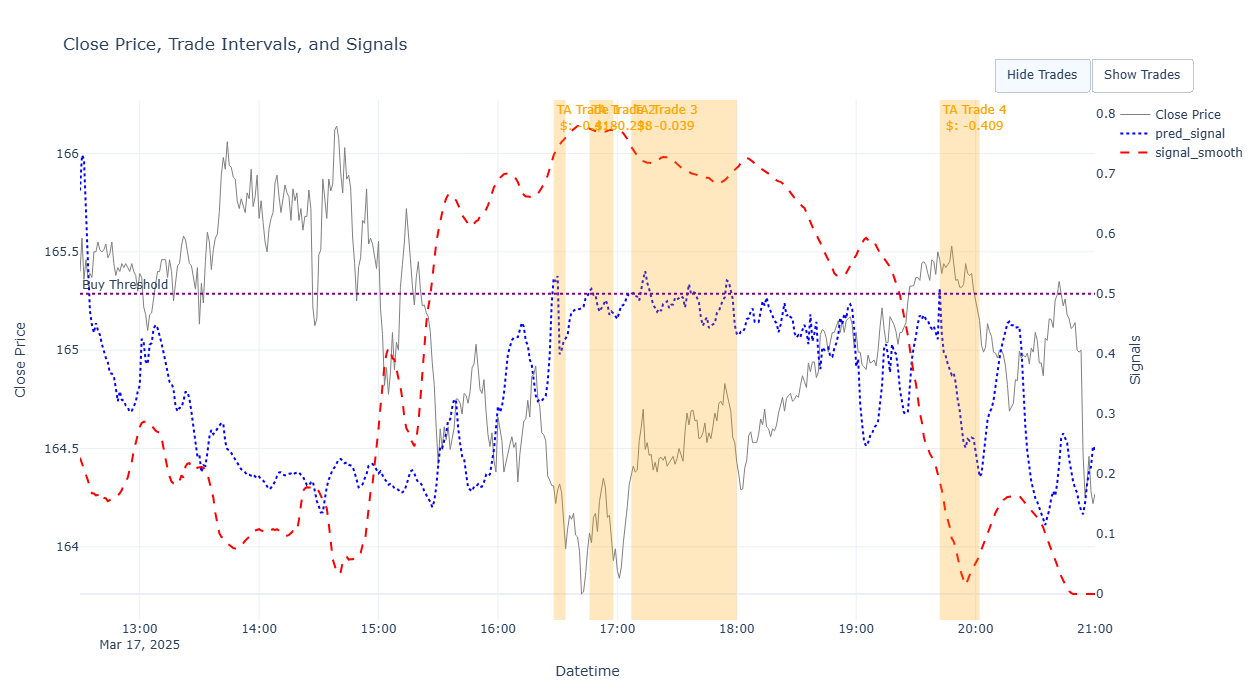


=== Performance for 2025-03-17 00:00:00 ===
Strategy Return ($): -1.105
Buy & Hold Return ($): -1.364
Trades Returns ($): [-0.418, -0.238, -0.039, -0.409]


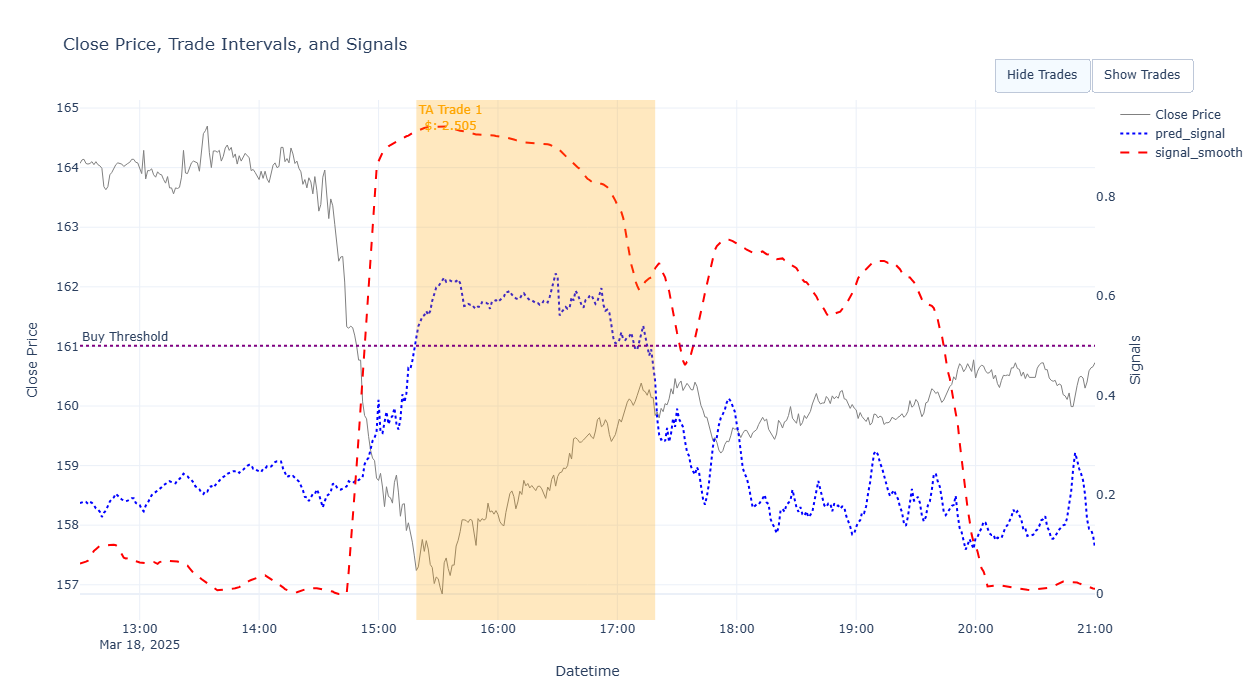


=== Performance for 2025-03-18 00:00:00 ===
Strategy Return ($): 2.505
Buy & Hold Return ($): -2.707
Trades Returns ($): [2.505]


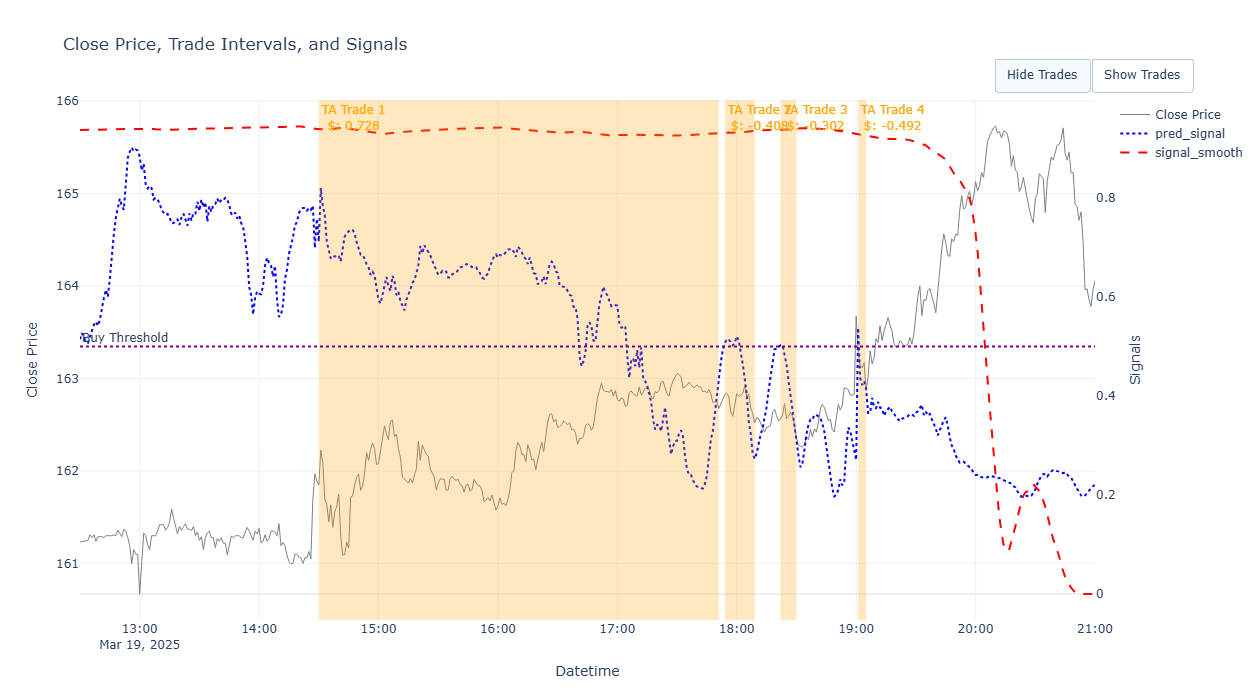


=== Performance for 2025-03-19 00:00:00 ===
Strategy Return ($): -0.474
Buy & Hold Return ($): 2.012
Trades Returns ($): [0.728, -0.408, -0.302, -0.492]


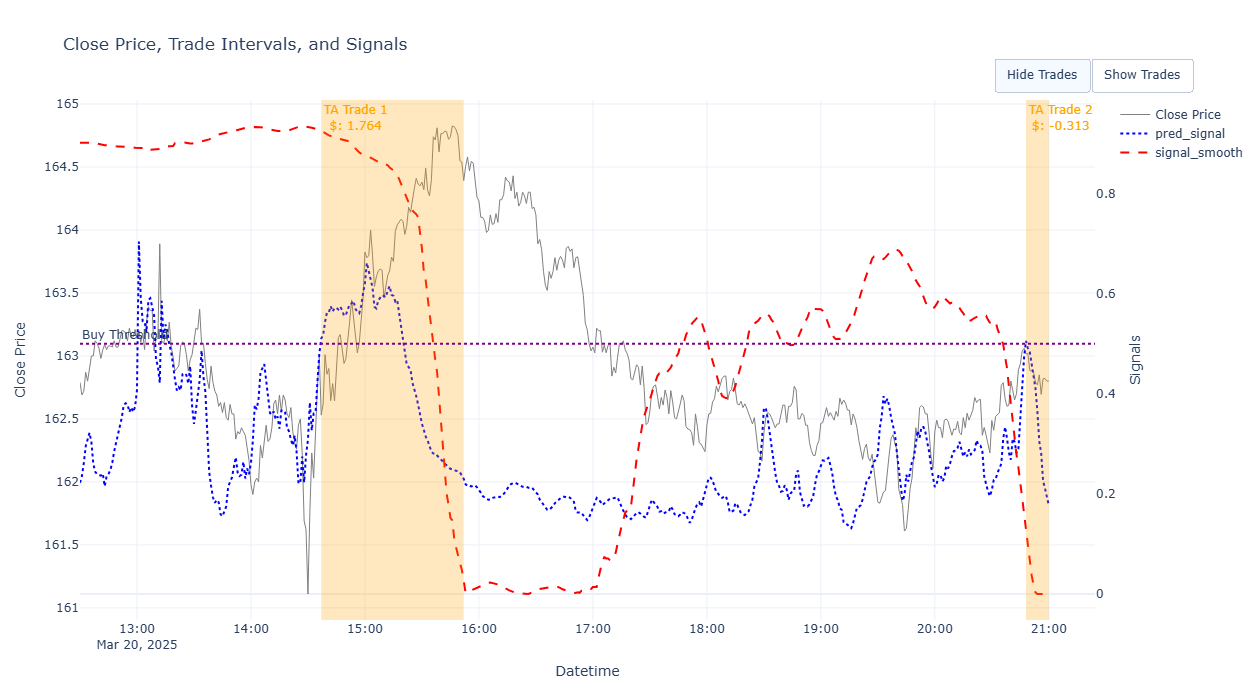


=== Performance for 2025-03-20 00:00:00 ===
Strategy Return ($): 1.451
Buy & Hold Return ($): 1.593
Trades Returns ($): [1.764, -0.313]


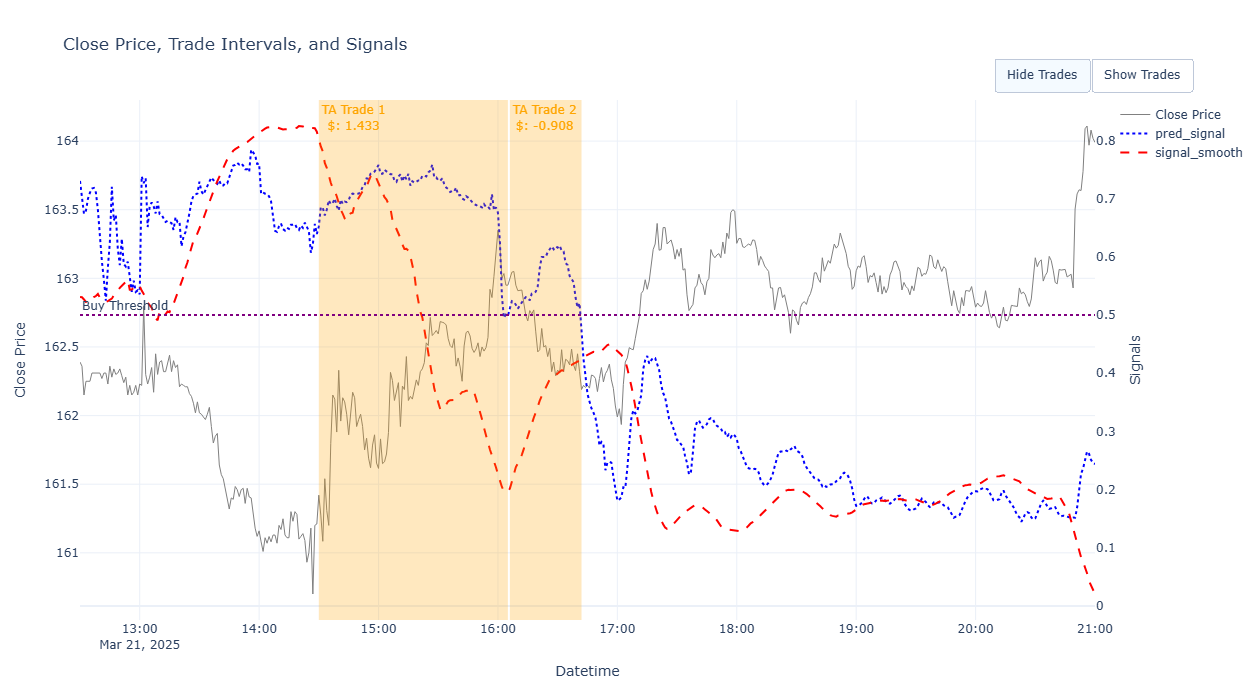


=== Performance for 2025-03-21 00:00:00 ===
Strategy Return ($): 0.525
Buy & Hold Return ($): 2.502
Trades Returns ($): [1.433, -0.908]


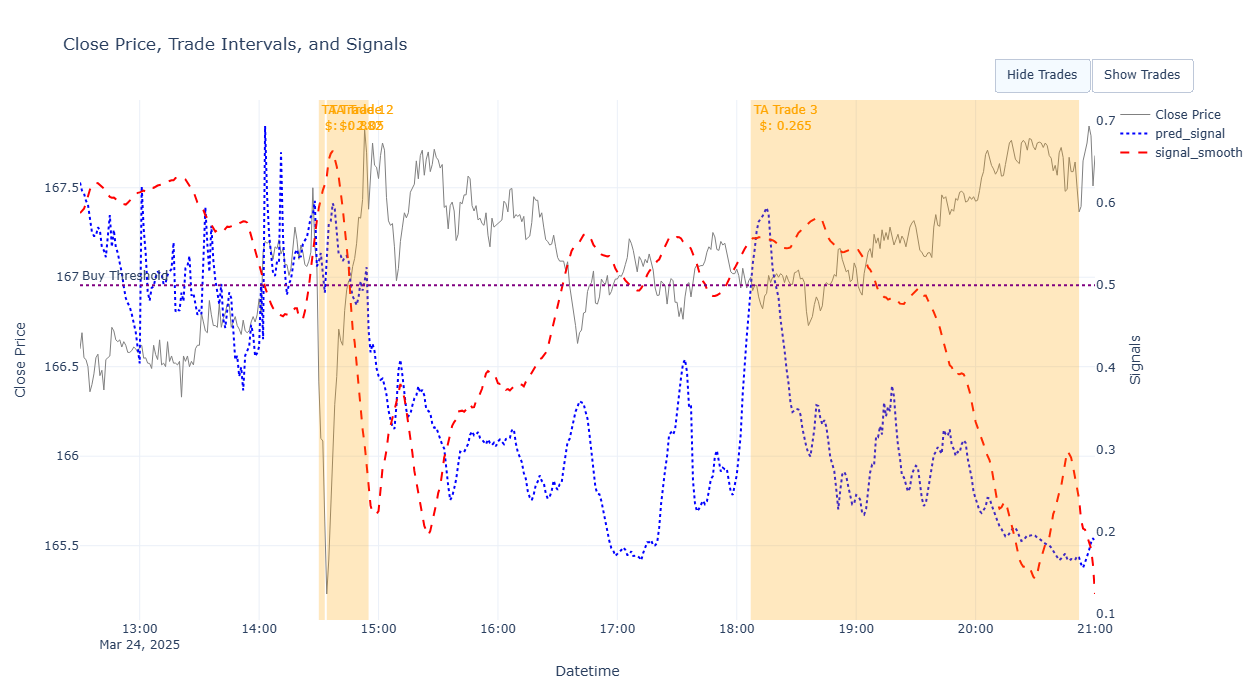


=== Performance for 2025-03-24 00:00:00 ===
Strategy Return ($): 1.433
Buy & Hold Return ($): 0.995
Trades Returns ($): [-0.882, 2.05, 0.265]


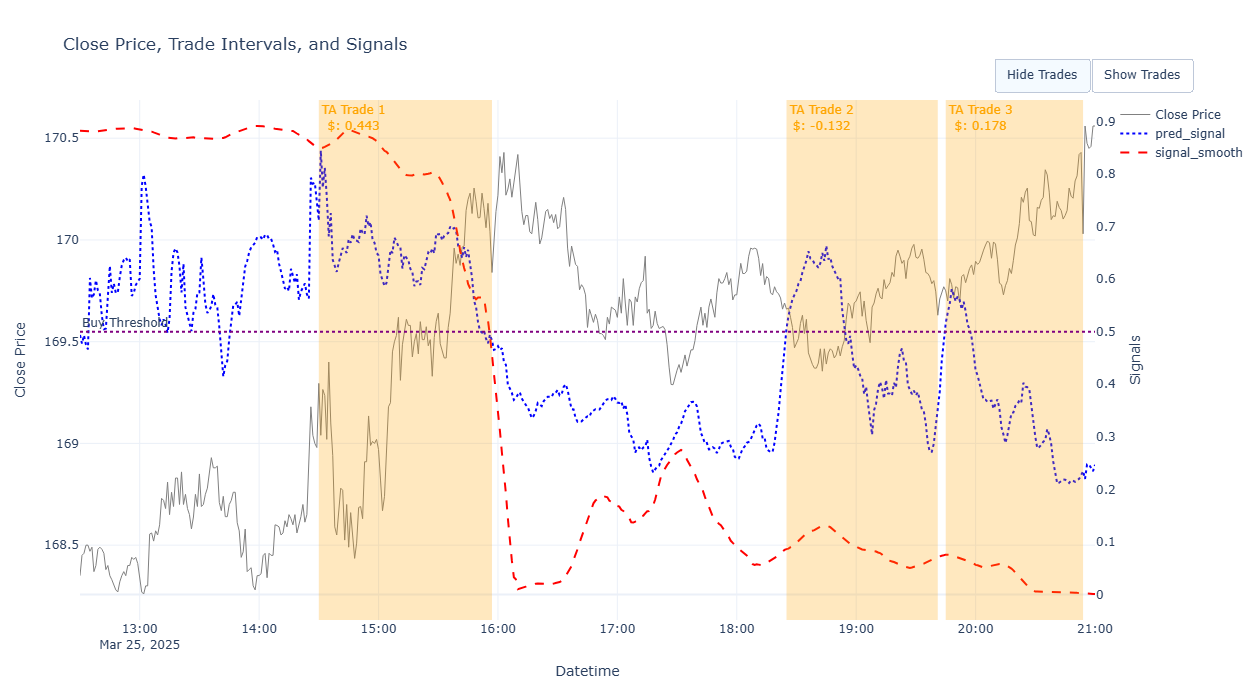


=== Performance for 2025-03-25 00:00:00 ===
Strategy Return ($): 0.489
Buy & Hold Return ($): 1.163
Trades Returns ($): [0.443, -0.132, 0.178]


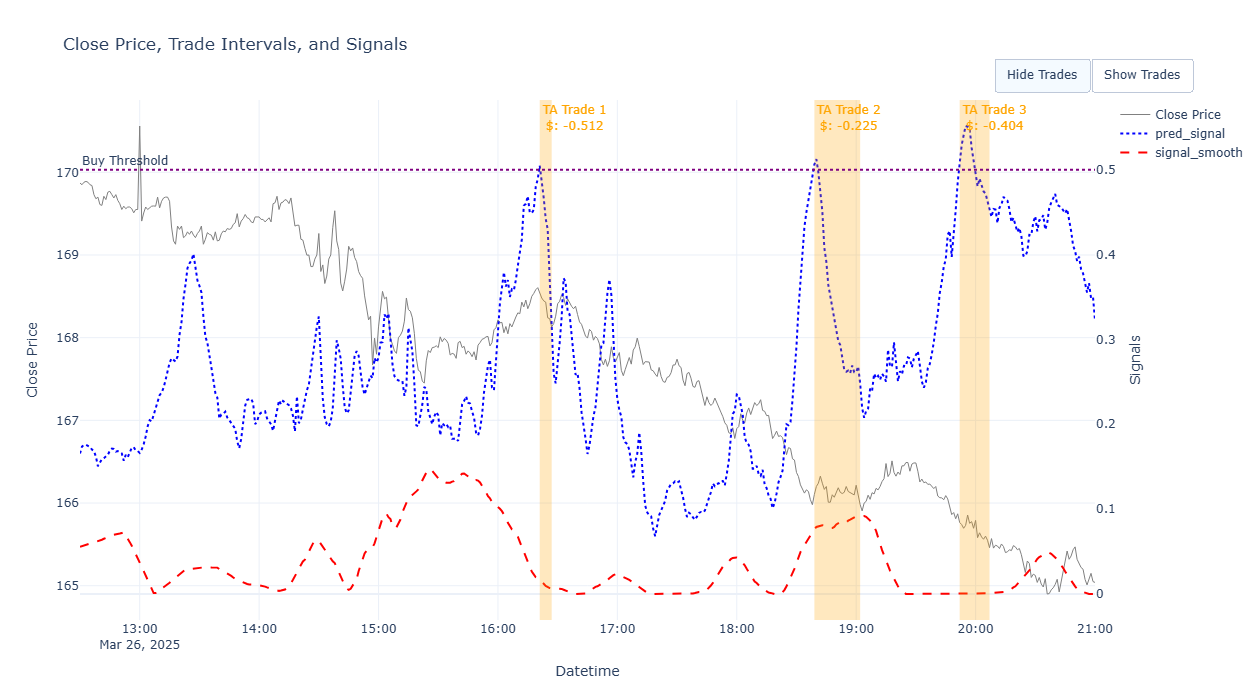


=== Performance for 2025-03-26 00:00:00 ===
Strategy Return ($): -1.14
Buy & Hold Return ($): -4.31
Trades Returns ($): [-0.512, -0.225, -0.404]


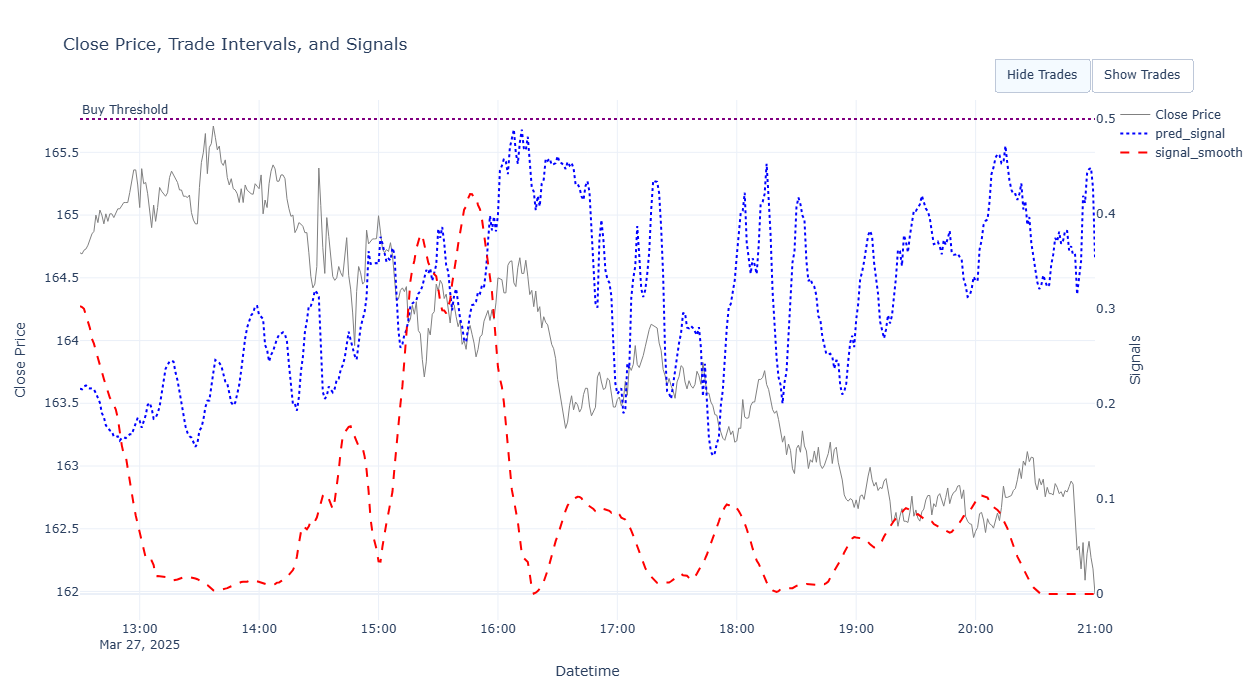


=== Performance for 2025-03-27 00:00:00 ===
Strategy Return ($): 0.0
Buy & Hold Return ($): -3.293
Trades Returns ($): []


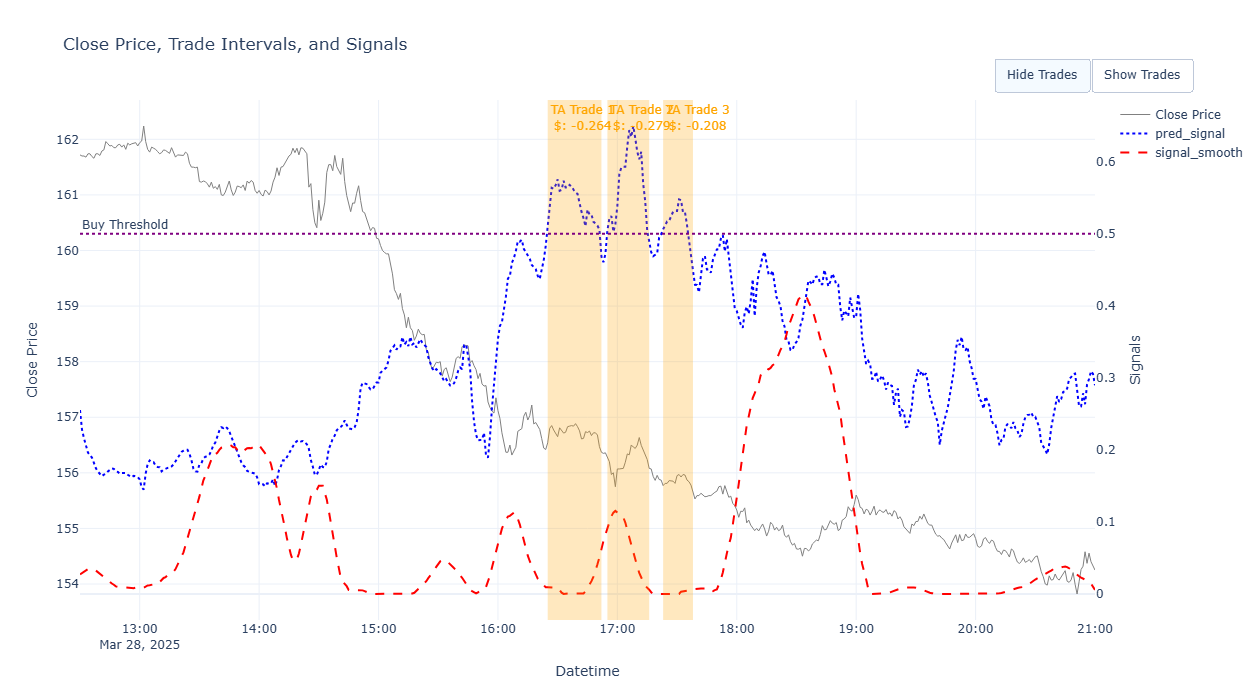


=== Performance for 2025-03-28 00:00:00 ===
Strategy Return ($): -0.751
Buy & Hold Return ($): -6.68
Trades Returns ($): [-0.264, -0.279, -0.208]


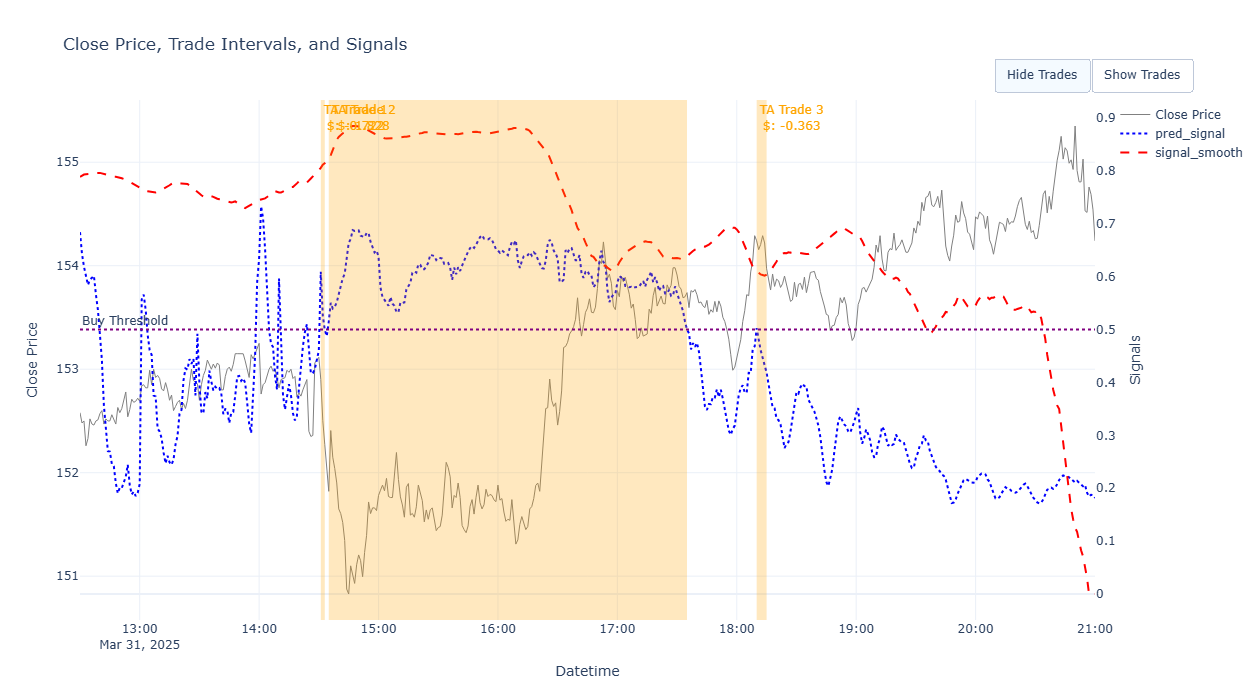


=== Performance for 2025-03-31 00:00:00 ===
Strategy Return ($): 0.744
Buy & Hold Return ($): 1.333
Trades Returns ($): [-0.722, 1.828, -0.363]

=== Overall Summary (2025-03-03 → 2025-03-31) ===
Start date price: 2025-03-03 = 171.5765
  End date price:  2025-03-31 = 154.1937
One-time buy&hold gain: -17.383

{'Buy & Hold – each day ($)': -7.712,
 'Strategy Return ($)': 15.126,
 'Trades Returns ($)': '55 trades'}

=== Overall Summary (2023-10-12 → 2025-06-18) ===
Start date price: 2023-10-12 = 140.4855
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 33.072

{'Buy & Hold – each day ($)': -77.566,
 'Strategy Return ($)': 291.565,
 'Trades Returns ($)': '1063 trades'}


In [16]:
year, month = map(int, date_to_check.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_check}")
else:
    print(f"\nPlotting days in {date_to_check}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_man,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_with_preds[df_with_preds.index.to_period("M") == date_to_check]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_with_preds)
pprint(overall_summary)
